In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional, Tuple


Siglip 2 - https://arxiv.org/pdf/2502.14786  : 2025 ppr

Siglip- https://arxiv.org/pdf/2303.15343  : Uses Sigmoid loss 

Clip ; https://arxiv.org/pdf/2103.00020 Uses cross entropy loss, cant parrelize 



In [3]:
# Check if CUDA is available and set the device accordingly
if torch.cuda.is_available():
    cuda_available = True
    devun = torch.device("cuda")
    devices = f"CUDA available: {torch.cuda.get_device_name(0)}"
    devices_list = [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())]
    print(f"Using CUDA device: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available, continuing with CPU")
    
print(f"Device: {devun}")

Using CUDA device: NVIDIA GeForce RTX 3050 Laptop GPU
Device: cuda


In [ ]:
class Siglip_vision_config:
    def __init__(
        self,
        hidden_size=768,
        intermediate_size=3072,
        num_attention_heads=12,
        num_hidden_layers=12,
        num_channels=3,
        image_size=224,
        patch_size=16,
        layer_norm_eps=1e-6,
        attention_probs_dropout_prob=0.0,
        num_image_tokens: int = None,
        **kwargs
        ):
        self.hidden_size = hidden_size
        self.intermediate_size = intermediate_size
        self.num_attention_heads = num_attention_heads
        self.num_hidden_layers = num_hidden_layers
        self.num_channels = num_channels
        self.image_size = image_size
        self.patch_size = patch_size
        self.layer_norm_eps = layer_norm_eps
        self.attention_probs_dropout_prob = attention_probs_dropout_prob
        self.num_image_tokens = num_image_tokens #if num_image_tokens is not None else (image_size // patch_size) ** 2


    

### Embeddings and Patch Extraction through convolution 
mentioned in Vision Transformer Paper: https://arxiv.org/pdf/2010.11929
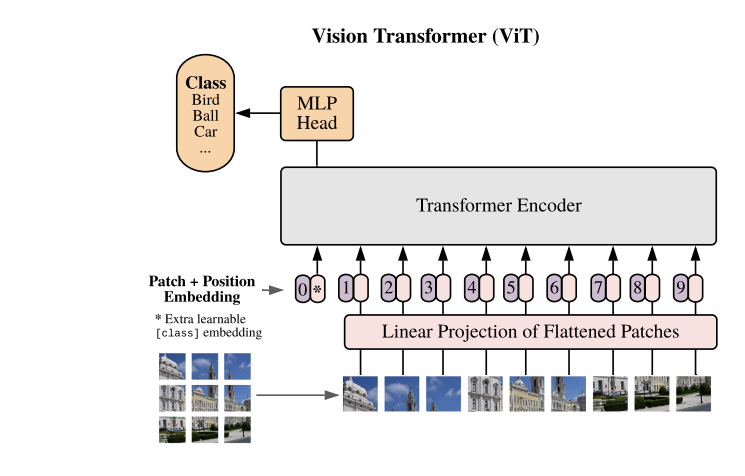


In [ ]:
class SiglipVisionEmbeddings(nn.Module):
    def __init__(self, config: Siglip_vision_config):
        super().__init__()
        self.config = config
        self.embedding_size = config.hidden_size
        self.image_size = config.image_size
        self.patch_size = config.patch_size
        self.num_channels = config.num_channels
        #extracting patches from the image, through convolution
        # The patch size is the size of the square patches to be extracted from the image
        # The embedding size is the size of the output feature vector for each patch
        self.patch_embeddings = nn.Conv2d(     
            in_channels=self.num_channels,
            out_channels=self.embedding_size,
            kernel_size=self.patch_size,
            stride=self.patch_size,
            padding="valid", # No padding 
        )
        
        self.num_patches = (self.image_size // self.patch_size) ** 2
        self.num_positions = self.num_patches 
        self.position_embeddings = nn.Embedding( self.num_positions, self.embedding_size)
        self.register_buffer( # This buffer is not a parameter, but it will be part of the model's state_dict
            "position_ids", 
            torch.arange(self.num_positions).expand((1, -1))
            persistent=False # This buffer will not be saved in the model's state_dict
            )
        
        
        
            
        

## SIGLIP_TRANSFORMER:

### Embeddings
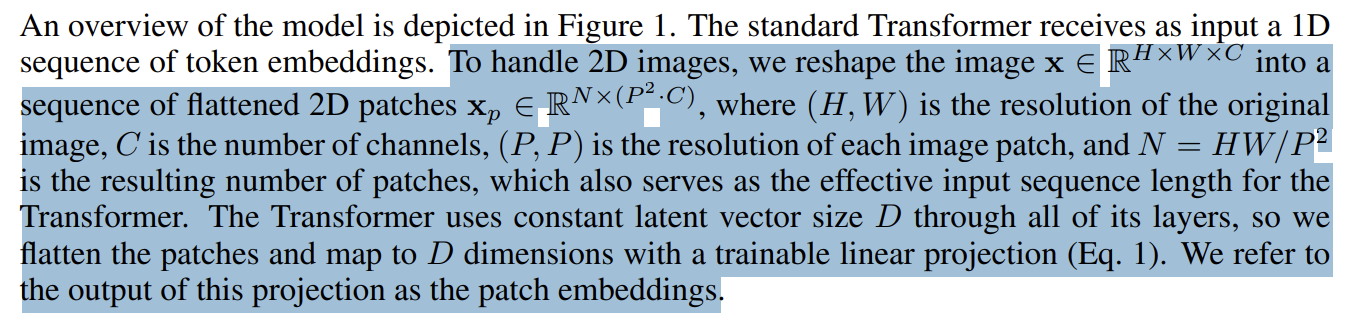

### Encoder

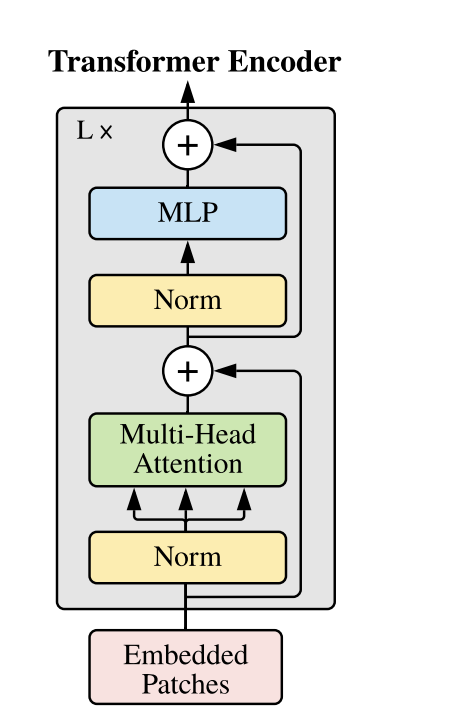
### LayerNorm
big change in input -> big change in output -> Significant change in loss -> big change in gradient -> big change in weights -> network learns slowly
Thus normalising the layers is important
"""We use nn.LayerNorm"""

embed_dim = 768

num_heads = 12

head_dim = 768 / 12 = 64

embed_dim = seq_len*num_heads 

.view().transpose(1,2) helped us reshape :
#### [batch_size, seq_len, embed_dim]->[batch_size, seq_len, num_heads, head_dim]-> [batch_size, num_heads, seq_len, head_dim] 
This is done so that you can process each head independently/parallely in the next steps (attention dot-products)



In [ ]:
class SiglipAttention(nn.Module):
    #MUlti-head attention
    def __init__(self, config: Siglip_vision_config):
        super().__init__()
        self.config = config
        self.embed_dim = config.hidden_size
        self.num_heads = config.num_attention_heads
        self.head_dim = self.embed_dim // self.num_heads 
        self.scale = self.head_dim ** -0.5 # (from self attention formula)
        self.dropout = config.attention_probs_dropout_prob #currently not used
        
        #q,k,v projections
        self.q_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.k_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.v_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.out_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.attention_dropout = nn.Dropout(self.dropout) #non existennt as of now
        #all are square matrices, once i was asked in an interview , about the dimentions of the matrices
        
       
        #hidden_states is of shape (batch_size, num_patches, hidden_size)
        
        
     
    #from "ATTETION IS ALL U NEED PPR"
    #The input is from fist layer layer_norm
    def forward(self,hidden_states : torch.Tensor)-> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        #the input is of shape (batch_size, num_patches/ basically the seq_len, hidden_size = 768)
        # in ViT  self-attention,  each token attends to all other tokens, thus no masking is needed
        query_states = self.q_proj(hidden_states)
        key_states = self.k_proj(hidden_states)
        value_states = self.v_proj(hidden_states)
        
        batch_size , seq_len ,_ = hidden_states.size() 
        num_heads = self.num_heads
        head_dim = self.head_dim
        # # we need to reshape to (batch_size, num_heads, seq_len, head_dim) FOR PARRALLELIZATION , CUZ ATTENTION IS CALCULATED IN PARALLEL FOR EACH HEAD
        
        query_states = query_states.view(batch_size, seq_len, num_heads, head_dim).transpose(1, 2)
        key_states = key_states.view(batch_size, seq_len, num_heads, head_dim).transpose(1, 2)
        value_states = value_states.view(batch_size, seq_len, num_heads, head_dim).transpose(1, 2)  
       # o/p of this will be (batch_size, num_heads, seq_len, head_dim)
        
        # Calculate the attention scores
        attn_scores = torch.matmul(query_states, key_states.transpose(-1, -2)) * self.scale   
        #scale refers to 1/sqrt(d_k) , for a particular head the it is 1/sqrt(head_dim)

        
        
          # ApplyING the softmax row-wise. attn_weights: [Batch_Size, Num_Heads, Num_Patches, Num_Patches]
        attn_weights = nn.functional.softmax(attn_weights, dim=-1, dtype=torch.float32).to(query_states.dtype)
        # Applying dropout only during training
        attn_weights = nn.functional.dropout(attn_weights, p=self.dropout, training=self.training)
        # Multiplying the attention weights by the value states. attn_output: [Batch_Size, Num_Heads, Num_Patches, Head_Dim] 
        attn_output = torch.matmul(attn_weights, value_states)
    

        if attn_output.size() != (batch_size, self.num_heads, seq_len, self.head_dim):
            raise ValueError(
                f"`attn_output` should be of size {(batch_size, self.num_heads, seq_len, self.head_dim)}, but is"
                f" {attn_output.size()}"
            )
        
        
        #now lets concatenate the heads
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.embed_dim)
        #attn_output: [Batch_Size, Num_Patches, Hidden_Size]
        
        attn_output = self.out_proj(attn_output)
        return attn_output, attn_weights
    
                                                                        
     
    ''' Happy that i could write the attention function from scratch,i can write this in my sleep now,
    well the next plan is to write this without torch, just numpy, and then write it in C++ and then in CUDA....'''
        
        

In [ ]:
class SiglipMLP(nn.Module):
    def __init__(self, config :Siglip_vision_config):
        super().__init__()
        self.config = config
        #Two fully connceted layers, here intermediate size 3072 as nentioned in the config 
        
        self.fc1 = nn.Linear(config.hidden_size, config.intermediate_size)
        self.fc2 = nn.Linear(config.intermediate_size, config.hidden_size)
    #forwad method for MLP 
    def forward(self, hidden_states:torch.Tensor)->torch.Tensor:
        hidden_states = self.fc1(hidden_states)
        #GElU is better than RELU for this application, why? idk  
        hidden_states = F.gelu(hidden_states)
        hidden_states = self.fc2(hidden_states)
        return hidden_states 
    # The forward method takes the input hidden states and applies the two linear transformations with GELU activation in between.
        
        
        
        

This is a single encoder layer

In [ ]:
class SiglipVisionEncoderLayer(nn.Module):
    def __init__(self, config : Siglip_vision_config): 
        super().__init__()
        
        self.config = config
        self.attention = SiglipAttention(config)
        self.layer_norm1 = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.mlp = SiglipMLP(config)
        self.layer_norm2 = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)
                
                
    def forward(
         self, 
         hidden_states: torch.Tensor,
     )-> torch.Tensor:
         #for further resiudual connection for the input
         residual = hidden_states #swill be used for skip connection 1
         #layer normalization
         hidden_states = self.layer_norm1(hidden_states) #this will be used as the input to the attention layer , class SiglipAttention
         #[batch_size, num_patches, Embedding_sizee/dimen]-> [batch_size, num_patches, Embedding_sizee/dimen = head ]
        # Apply self-attention
         attention_output = self.attention(hidden_states)
         
         hidden_states= residual + attention_output #skip connection 1
         #for skip connection 2
         residual = hidden_states

         hidden_states = self.layer_norm2(hidden_states)
        # Apply MLP
         mlp_output = self.mlp(hidden_states)
        # Add & Norm
         hidden_states = residual + mlp_output #skip connection 2
         
         
         return hidden_states

NameError: name 'nn' is not defined

The embeddings goes through L number of times through a single encoder layer, as shown in above diagram 

In [ ]:
class SiglipVisionEncoder(nn.Module):
    def __init__(self,config: Siglip_vision_config):
        super().__init__()
        self.config = config
        self.layer = nn.ModuleList(
            [SiglipVisionEncoderLayer(config) for _ in range(config.num_hidder_layers)]
        ) 
#here we are using nn.ModuleList to create a list of layers, so that we can use them in a loop
        def forward(self, hidden_states:torch.Tensor)->torch.Tensor:
            #hidden_states is of shape (batch_size, num_patches, hidden_size)
            for layer in self.layer:
                hidden_states = layer(hidden_states)
            return hidden_states
        #shape is unchanged, but the values are changed

In [ ]:
class Siglip_vision_transformer(nn.Module):
    def __init__(self, config: Siglip_vision_config): 
        super().__init__()
        self.config = config
        embed_dim = config.hidden_size
        self.embeddings = SiglipVisionEmbeddings(config)
        self.encoder = SiglipVisionEncoder(config)
        self.post_layernorm = nn.LayerNorm(embed_dim, eps=config.layer_norm_eps)
    
    
    def forward(self,pixel_values: torch.tensor ) -> torch.tensor:
       
        hidden_states = self.embeddings(pixel_values)# 
        last_hidden_state = self.encoder(hidden_states)  # we use encoder to get the last hidden state
        # Apply layer normalization to the last hidden state
        
        last_hidden_state = self.post_layernorm(input_embeds = last_hidden_state)
        
        return last_hidden_state
        
        
        

In [ ]:
class SigLIPVisionModel(nn.Module):
    def __init__(self, config: Siglip_vision_config):
        super()().__init__()
        self.config = config
        self.vision_model = Siglip_vision_transformer(config)
        

Forward Propagrationn


In [ ]:
def forward(self, pixel_values : torch.FloatTensor) -> torch.Tensor:
     _, _, height, width = pixel_values.shape #Batch size, number of channels, height, width
     
    #we need to convolve the image to get the patches, i.e the "patch_size"
     patch_embeds= self.patch_embeddings(pixel_values)
      # (batch_size, embedding_size, height, width)
    
    # Now, we need to Reshape the patch embeddings to (batch_size, num_patches, embedding_size)
     embeddings = patch_embeds.flatten(2).transpose(1, 2) # (batch_size, num_patches, embedding_size)
     
    #addings positional embeddings
    # The position_ids are the indices of the patches in the flattened tensor, these are learned embeddings
    # The position embeddings are added to the patch embeddings to give each patch a unique position in the sequence
     embeddings = embeddings + self.position_embeddings(self.position_ids)  
     #[batch_size, num_patches, embedding_size]
    # The embeddings are then passed through the encoder, which applies self-attention and feed-forward layers
     
   # return self.vision_model(pixel_values=pixel_values)

NameError: name 'torch' is not defined